<font size = "6">4 Predictive Analysis </font>

Our research so far has been mainly about inspecting and analysing the as-is situation. However, in this section aim to go a step further and create tools for predicting future, hourly demand.
Having an accurate prediciton of the demand can be quite critical, as the company can better prepare for the situation. It can help in schedulig repairs or additional bikes and thus help reduce costs and increase revenue.

To actually take advantage of those benefits, we will fit different prediction models on our prepared data, in order to find the best fitting one.


<font size = "4"><b>Imports </b> </font>

We started by importing all of our needed tools and libraries. Also, we loaded our cleaned trips- and weather data and brought them into a dataframe form. Furthermore, we created a performance dataframe, which will store all of our performance indexes needed for the model evaluation later on.

<b>NOTE:</b> Please run the command <b> pip install ipynb </b> before executing the import cell. This command allowed us to use our model_evaluation function from a different file.

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib as mp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.pyplot import figure
import datetime
from datetime import timedelta
import seaborn as sns
#import graphviz
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso, Ridge, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsClassifier
from ipynb.fs.full.Model_Evaluation import model_evaluation
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Feaure Engineering

In [2]:
df_chicago = pd.read_csv('../dataset/chicago_2018_clean.csv')
df_weather = pd.read_csv('../dataset/chicago_weather_2018_clean.csv')

# Disclaimer: When we later on talk about demand, we always mean the hourly demand
# Also the column 'Demand' which will be added later on, is representing the hourly demand

In [3]:
df_performance = pd.DataFrame(columns = ['Feature Set', 'Prediction Model', 'MSE', 'R^2'])

Sorting our data is not a crucial step, but allows us to have an inital overview of the different starting times (vielleicht noch umschreiben dont know)

In [572]:
df_sorted = df_chicago.sort_values(by=['start_time'], ascending = [True])
df_sorted.head(5)

,start_time,end_time,start_station_id,end_station_id,start_station_name,end_station_name,bike_id,user_type,duration_per_trip,trip_time_in_hours
3212538,2018-01-01 00:12:00,2018-01-01 00:17:23,69,159,Damen Ave & Pierce Ave,Claremont Ave & Hirsch St,3304,Subscriber,0 days 00:05:23,0.089722
3212539,2018-01-01 00:41:35,2018-01-01 00:47:52,253,325,Winthrop Ave & Lawrence Ave,Clark St & Winnemac Ave (Temp),5367,Subscriber,0 days 00:06:17,0.104722
3212540,2018-01-01 00:44:46,2018-01-01 01:33:10,98,509,LaSalle St & Washington St,Troy St & North Ave,4599,Subscriber,0 days 00:48:24,0.806667
3212541,2018-01-01 00:53:10,2018-01-01 01:05:37,125,364,Rush St & Hubbard St,Larrabee St & Oak St,2302,Subscriber,0 days 00:12:27,0.207500
3212542,2018-01-01 00:53:37,2018-01-01 00:56:40,129,205,Blue Island Ave & 18th St,Paulina St & 18th St,3696,Subscriber,0 days 00:03:03,0.050833


<font size = "6">4.1 Feature Engineering </font>

Here we lay the foundation for our following predictions. We aim to engineer experessive features from our, which will later on contribute to our prediction performance. 

We start with the preparing and merging the cleaned trip- and weather data.

In [4]:
#rename date_time column of df_weather in order to successfully merge system load and weather dataframe later on
df_weather.rename(columns = {'date_time':'start_time'}, inplace = True)
#convert now start_time column to datetime format in order to merge later on
df_weather['start_time'] = pd.to_datetime(df_weather['start_time'])
df_weather.head(5)

,start_time,max_temp,min_temp,precip
0,2018-01-01 00:00:00,-13.9,-13.9,0.0
1,2018-01-01 01:00:00,-15.0,-15.0,0.0
2,2018-01-01 02:00:00,-15.6,-15.6,0.0
3,2018-01-01 03:00:00,-16.7,-16.7,0.0
4,2018-01-01 04:00:00,-17.2,-17.2,0.0


Out of our cleaned trip-data, we engineer our most important variable and future label, our hourly demand.

In [5]:
#we calculate the hourly system demand by summing up the number of biketrips started in one hour
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])
df_sorted['end_time'] = pd.to_datetime(df_sorted['end_time'])
df_load = df_sorted.groupby([pd.Grouper(key='start_time',freq='H')]).size().reset_index(name='Demand')
df_load.head(5)

,start_time,Demand
0,2018-01-01 00:00:00,7
1,2018-01-01 01:00:00,14
2,2018-01-01 02:00:00,10
3,2018-01-01 03:00:00,2
4,2018-01-01 04:00:00,2


We finally merge our trip- and weather data together to one dataframe. Further, we calculate the average temperature during each trip, to use as possible feature later on.

In [6]:
# merge Demand dataframe with weather dataframe
# calculate average temperature within the hour to check correlation with demand later on

df_load_weather = pd.merge(df_load, df_weather, on='start_time')
#calculate average ter
df_load_weather['avg_temp'] = (df_load_weather['max_temp'] + df_load_weather['min_temp'])/2
#since we only inspect the average temperature in the hour, we can drop the max_temp and min_temp columns
df_load_weather.head(5)

,start_time,Demand,max_temp,min_temp,precip,avg_temp
0,2018-01-01 00:00:00,7,-13.9,-13.9,0.0,-13.9
1,2018-01-01 01:00:00,14,-15.0,-15.0,0.0,-15.0
2,2018-01-01 02:00:00,10,-15.6,-15.6,0.0,-15.6
3,2018-01-01 03:00:00,2,-16.7,-16.7,0.0,-16.7
4,2018-01-01 04:00:00,2,-17.2,-17.2,0.0,-17.2


We drop our max_temp and min_temp features, since we only look at the average temperature. The temperature usually does not fluctuate very much during the most trips, which is why the average temperature is sufficient as a possible feature.

In [7]:
df_load_weather.drop(['max_temp', 'min_temp'], axis = 1, inplace = True)
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp
0,2018-01-01 00:00:00,7,0.0,-13.9
1,2018-01-01 01:00:00,14,0.0,-15.0
2,2018-01-01 02:00:00,10,0.0,-15.6
3,2018-01-01 03:00:00,2,0.0,-16.7
4,2018-01-01 04:00:00,2,0.0,-17.2


Here we create a new column, which only stores the hour of the start_time. We do this, since we later want to calculate the correlation between the features and label. This operation is not possible with an object of the type datetime. Hence, we convert it an int object "start_hour", which makes this operation possible

In [8]:
df_load_weather['start_hour'] = df_load_weather['start_time'].dt.hour

Some data, like time behaves in cyclical patterns. We understand that hour 0 comes directly after hour 23. But our regression models do not know that and thus assume that those times are vastly apart from each other. 
In order to get precise results from our models we need to find a way to represent cyclical data in a cyclical way. We do this, by applying both a cosinus and sinus function. This way our models are able to accurately assess the times of the bike trips.

We also apply this method to our start_month and later to our day_of_Week features.

In [9]:
df_load_weather['sin_hour'] = np.sin(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather['cos_hour'] = np.cos(2*np.pi*df_load_weather['start_hour']/24)
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000


In [10]:
# create new column for start_month
# same as for start_hour: we want to check the correlation between the month the trips are in and the demand
df_load_weather['start_month'] = df_load_weather['start_time'].dt.month

# The start month is also a cyclical feature, which is why we need also need to transform it
df_load_weather['sin_month'] = np.sin(2*np.pi*(df_load_weather['start_month'])/12)
df_load_weather['cos_month'] = np.cos(2*np.pi*df_load_weather['start_month']/12)

df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025


Here we create a new feature, which will determine, if the day in question was a holiday in chicago.
The following day where holidays in Illinois (the state chicago is located in):

01.01, 15.01, 12.02, 19.02, 05.03, 28.05, 04.07, 03.09, 08.10, 06.11, 12.11, 22.11, 23.11, 05.12, 24.12, 25.12

Source: (noch hinzufügen)

In [11]:
holidays = np.array([
    datetime.date(2018,1,1),
    datetime.date(2018,1,15),
    datetime.date(2018,2,12),
    datetime.date(2018,2,19),
    datetime.date(2018,3,5),
    datetime.date(2018,5,28),
    datetime.date(2018,7,4),
    datetime.date(2018,9,3),
    datetime.date(2018,10,8),
    datetime.date(2018,11,6),
    datetime.date(2018,11,12),
    datetime.date(2018,11,22),
    datetime.date(2018,11,23),
    datetime.date(2018,12,5),
    datetime.date(2018,12,24),
    datetime.date(2018,12,25),
])
print(holidays)

[datetime.date(2018, 1, 1) datetime.date(2018, 1, 15)
 datetime.date(2018, 2, 12) datetime.date(2018, 2, 19)
 datetime.date(2018, 3, 5) datetime.date(2018, 5, 28)
 datetime.date(2018, 7, 4) datetime.date(2018, 9, 3)
 datetime.date(2018, 10, 8) datetime.date(2018, 11, 6)
 datetime.date(2018, 11, 12) datetime.date(2018, 11, 22)
 datetime.date(2018, 11, 23) datetime.date(2018, 12, 5)
 datetime.date(2018, 12, 24) datetime.date(2018, 12, 25)]


In [12]:
df_load_weather['start_time'] = pd.to_datetime(df_load_weather['start_time'])
df_load_weather['isHoliday'] = df_load_weather['start_time'].dt.date.isin(holidays)

# To make sure that the correlation is calculated properly, we transform the currently boolean values
# of isHoliday to int values: 1 = this date was a holiday; 2 = this date wasn't a holiday
df_load_weather['isHoliday'] = df_load_weather['isHoliday'].astype(int)

df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1


Here we create a new feature day_of_Week, which represents which day of the Week the trip was taken in. For this, we create dummy-variables, which represent the day an can be used by our models:

day_of_Week: 1 = Monday, 2 = Tuesday, 3 = Wednesday, 4 = Thursday, 5 = Fridasy, 6 = Saturday, 7 = Sunday

In [13]:
df_load_weather['day_of_Week'] = df_load_weather['start_time'].dt.isocalendar().day

# Since day_of_Week is once again a cyclical feature, we again need to transform it in order to have continous data
# instead of interrupt changes when the new week begins

df_load_weather['sin_day_of_Week'] = np.sin(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather['cos_day_of_Week'] = np.cos(2*np.pi*df_load_weather['day_of_Week']/7)
df_load_weather.head(5)


,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,1,0.781831,0.62349
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,1,0.781831,0.62349
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,1,0.781831,0.62349
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,1,0.781831,0.62349
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,1,0.781831,0.62349


Again, we create a new column, called season. We aim to categorize our bike-trips into the four season Winter, Spring, Summer, Autumn, in order to again check for possible correlation with the demand.
As with the day_of_Week column, we utilize dummy variables to represent the seasons.

season: 1 = Winter {Dec, Jan, Feb}; 2 = Spring {Mar, April, May}; 3 = Summer {June, July, Aug}; 4 = Autumn {Sep, Oct, Nov}

Technically seasons would also be a cyclical feature, which we would also have to convert into cyclical form. However, since we only inspect one year, seasons will only appear once, rendering a conversion redundant.

In [584]:
seasons = [1, 1, 2, 2, 2, 3, 3, 3, 4, 4, 4, 1]

monthToSeason = dict(zip(range(1,13), seasons))

df_load_weather['season'] = df_load_weather['start_time'].dt.month.map(monthToSeason)
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,1,0.781831,0.62349,1
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,1,0.781831,0.62349,1
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,1,0.781831,0.62349,1
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,1,0.781831,0.62349,1
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,1,0.781831,0.62349,1


Looking at our trip patterns, created earlier, we found that a lot of trips take place during the usual rush-hours. Namely, between 06:00 and 08:00, as well as between 16:00 and 18:00.

Therefore, we create a new feature in_rush_Hour, which determines, if a bike-trip is within those time intervals.

Dummy-variable:
in_rush_Hour: 1 = time is in rush-hour; 0 = time is not in rush-hour

In [585]:
df_load_weather['in_rush_Hour'] = False
df_load_weather['in_rush_Hour'] = np.where((df_load_weather['start_time'].dt.time.ge(datetime.time(6,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(8,0,0)))
                                              | (df_load_weather['start_time'].dt.time.ge(datetime.time(16,0,0)) & df_load_weather['start_time'].dt.time.le(datetime.time(18,0,0))),1,0
                                          
                                          )

We wanted to check, if the demand from one hour ago is of any help for predicting the demand, which is why we created a new feature prev_Demand for it.

In [586]:
df_load_weather['prev_Demand'] = df_load_weather['Demand'].shift()
df_load_weather.head(5)

,start_time,Demand,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
0,2018-01-01 00:00:00,7,0.0,-13.9,0,0.000000,1.000000,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,NaN
1,2018-01-01 01:00:00,14,0.0,-15.0,1,0.258819,0.965926,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,7.0
2,2018-01-01 02:00:00,10,0.0,-15.6,2,0.500000,0.866025,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,14.0
3,2018-01-01 03:00:00,2,0.0,-16.7,3,0.707107,0.707107,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,10.0
4,2018-01-01 04:00:00,2,0.0,-17.2,4,0.866025,0.500000,1,0.5,0.866025,1,1,0.781831,0.62349,1,0,2.0


In the next step, we want to plot our demand to have a visualization of our data. This gives us an inital idea on how our regression should look like in the future and thus helps us with finding the fitting parameters

First we prepare some custom dataframes that help us to plot the data clearly. 
We calculated the total daily demand and the average daily temperature and later plot this data

In [587]:
df_sorted['start_time'] = pd.to_datetime(df_sorted['start_time'])

df_var = df_load_weather[['start_time', 'avg_temp']]
df_temp_daily = df_var.groupby([pd.Grouper(key='start_time',freq='D')]).mean().reset_index()

df_load_daily = df_sorted.groupby([pd.Grouper(key='start_time',freq='D')]).size().reset_index(name='Demand')
df_temp_daily.head(5)

,start_time,avg_temp
0,2018-01-01,-18.912500
1,2018-01-02,-19.125000
2,2018-01-03,-11.450521
3,2018-01-04,-13.908333
4,2018-01-05,-15.237500


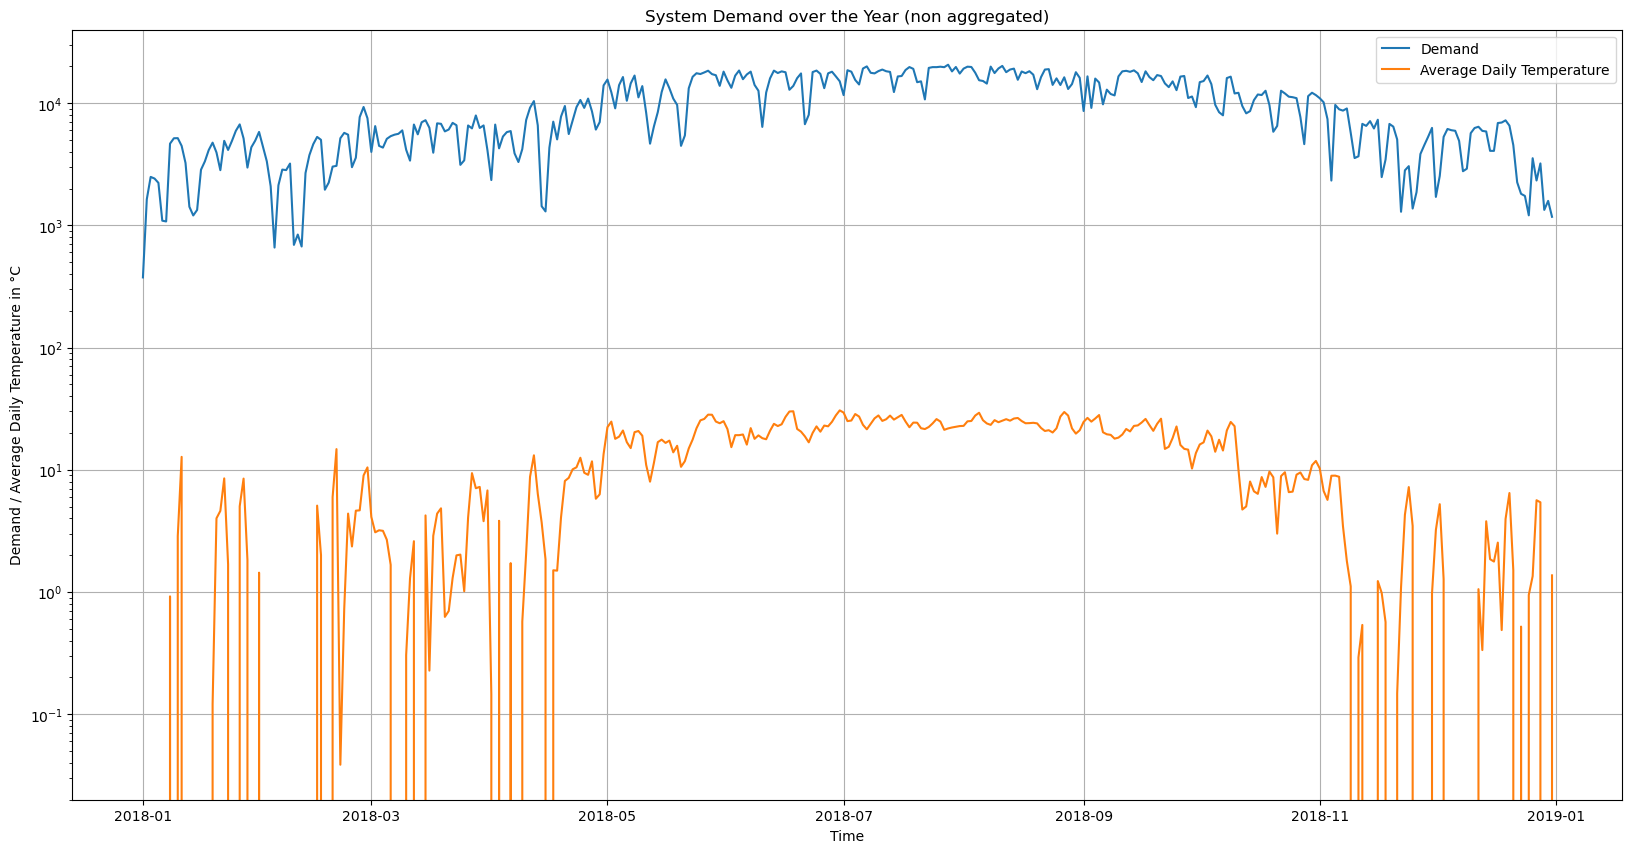

In [588]:
plt.semilogy(df_load_daily['start_time'], df_load_daily['Demand'], df_load_daily['start_time'], df_temp_daily['avg_temp'])
plt.title('System Demand over the Year (non aggregated)')
plt.xlabel('Time')
plt.ylabel('Demand / Average Daily Temperature in °C')
plt.grid(True)
plt.gcf().set_size_inches(20,10)
plt.legend(["Demand", "Average Daily Temperature"])



#plt.show()

#plt.plot(df_temp_daily['start_time'],df_temp_daily['avg_temp'], "r-")
#plt.title('Average Temperature in °C over the Year')
#plt.xlabel('Time')
#plt.ylabel('Average Temperature in °C')
#plt.grid(True)
#plt.show()


<font size = "6">4.1.1 Feature Selection </font>

We now have all of our possible features in a dataframe. Now, the task at hand is, selecting which of those features are actually useful for our predictions later. We aim to filter out the combination of features, which gives us the most precise prediction later one.
For filtering out those features, we utilize two methods. First, a Lasso (also called L1) regression and second a correlation-matrix. The lasso regression will already return us an indicator on how important each of our selected features is, but we also wanted to show that the correlation matrix paints a similar picture.

We start by splitting our data into training- and test datasets, to enable our model to cross-validate and therefore increase precision of the tuned hyperparameter lambda. 
We perfrom the split and drop a row that contains NaN values. Due to our extensive cleansing and preparing of the data earlier, no NaN values are in the dataset. However, by creating the prev_Demand column earlier, the first row of our dataset contains a NaN value in this column. Since one row is not too influencial, considering the amount of data we have, we can easily drop this row, without repercussions.

Next, we create a pipeline, which is later utilized for telling the gridsearch, which model and scaler to use. Since the normalize function was depreceated, utilizing the standardscaler has become best practice. Especially when utilizing L1 or L2 regression, scaling the data is essential. Those models put heavy penalty on high magnitudes of features, rendering them almost as non existent. So in order to avoid penalty to unscaled and unnormalized values, we utilize the standardscaler

After that, we start the GridSearchCV, which is testing values for the regularization paramter lambda (in pyhton called alpha) to determine to one with the best performance. Our performance indicator here is the negative mean squared error. 

We fit our model to our training data and retain the best value for lambda: 0.5.
With this hyperparameter successfully tuned, we let the L1 regression give us the importance of our features with the function best_estimator_.named_steps['model'].coef_. Here the rule is, the father the coefficient of a feature is from zero, the more important it is for the prediction.

In [589]:
#splitting data into training and testing data, with a 70% training / 30% testing ratio

df_split = df_load_weather
df_split.set_index('start_time',inplace = True)

train_lasso, test_lasso = train_test_split(df_split, test_size = 0.3, random_state = 42)

# Drop every row that contains nan values in order for regression to work properly
test_lasso.dropna(inplace = True)
train_lasso.dropna(inplace = True)

X_train_lasso = train_lasso.iloc[:,1:]
y_train_lasso = train_lasso.iloc[:,:1]

X_test_lasso = test_lasso.iloc[:,1:]
y_test_lasso = test_lasso.iloc[:,:1]

pipeline_lasso = Pipeline([('scaler',StandardScaler()),
                    ('model', Lasso())
                     ])


search_lasso = GridSearchCV (pipeline_lasso,
                    {'model__alpha':np.arange(0.1, 10, 0.1)},
                      cv = 5, scoring = "neg_mean_squared_error", verbose=3
                      )

# when increasing the lambda range from 10 to 50, the optimal value remains at 0.5

search_lasso.fit(X_train_lasso, y_train_lasso)
print (search_lasso.best_params_)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END .............model__alpha=0.1;, score=-34388.866 total time=   0.0s
[CV 2/5] END .............model__alpha=0.1;, score=-47053.589 total time=   0.0s
[CV 3/5] END .............model__alpha=0.1;, score=-42533.635 total time=   0.0s
[CV 4/5] END .............model__alpha=0.1;, score=-44312.835 total time=   0.0s
[CV 5/5] END .............model__alpha=0.1;, score=-43099.533 total time=   0.0s
[CV 1/5] END .............model__alpha=0.2;, score=-34387.309 total time=   0.0s
[CV 2/5] END .............model__alpha=0.2;, score=-47055.499 total time=   0.0s
[CV 3/5] END .............model__alpha=0.2;, score=-42518.945 total time=   0.0s
[CV 4/5] END .............model__alpha=0.2;, score=-44320.538 total time=   0.0s
[CV 5/5] END .............model__alpha=0.2;, score=-43098.713 total time=   0.0s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-34386.657 total time=   0.0s
[CV 2/5] END model__alpha=0.3000000000000000

[CV 3/5] END .............model__alpha=2.2;, score=-42263.169 total time=   0.0s
[CV 4/5] END .............model__alpha=2.2;, score=-44671.062 total time=   0.0s
[CV 5/5] END .............model__alpha=2.2;, score=-43198.347 total time=   0.0s
[CV 1/5] END model__alpha=2.3000000000000003;, score=-34476.226 total time=   0.0s
[CV 2/5] END model__alpha=2.3000000000000003;, score=-47249.241 total time=   0.0s
[CV 3/5] END model__alpha=2.3000000000000003;, score=-42256.834 total time=   0.0s
[CV 4/5] END model__alpha=2.3000000000000003;, score=-44693.398 total time=   0.0s
[CV 5/5] END model__alpha=2.3000000000000003;, score=-43207.795 total time=   0.0s
[CV 1/5] END model__alpha=2.4000000000000004;, score=-34481.069 total time=   0.0s
[CV 2/5] END model__alpha=2.4000000000000004;, score=-47265.433 total time=   0.0s
[CV 3/5] END model__alpha=2.4000000000000004;, score=-42251.077 total time=   0.0s
[CV 4/5] END model__alpha=2.4000000000000004;, score=-44716.109 total time=   0.0s
[CV 5/5] E

[CV 1/5] END .............model__alpha=4.3;, score=-34640.163 total time=   0.0s
[CV 2/5] END .............model__alpha=4.3;, score=-47603.737 total time=   0.0s
[CV 3/5] END .............model__alpha=4.3;, score=-42193.210 total time=   0.0s
[CV 4/5] END .............model__alpha=4.3;, score=-45218.795 total time=   0.0s
[CV 5/5] END .............model__alpha=4.3;, score=-43432.473 total time=   0.0s
[CV 1/5] END model__alpha=4.3999999999999995;, score=-34652.066 total time=   0.0s
[CV 2/5] END model__alpha=4.3999999999999995;, score=-47623.216 total time=   0.0s
[CV 3/5] END model__alpha=4.3999999999999995;, score=-42194.089 total time=   0.0s
[CV 4/5] END model__alpha=4.3999999999999995;, score=-45248.991 total time=   0.0s
[CV 5/5] END model__alpha=4.3999999999999995;, score=-43446.908 total time=   0.0s
[CV 1/5] END .............model__alpha=4.5;, score=-34664.323 total time=   0.0s
[CV 2/5] END .............model__alpha=4.5;, score=-47643.028 total time=   0.0s
[CV 3/5] END .....

[CV 3/5] END .............model__alpha=6.4;, score=-42258.333 total time=   0.0s
[CV 4/5] END .............model__alpha=6.4;, score=-45645.526 total time=   0.0s
[CV 5/5] END .............model__alpha=6.4;, score=-43692.594 total time=   0.0s
[CV 1/5] END .............model__alpha=6.5;, score=-34847.458 total time=   0.0s
[CV 2/5] END .............model__alpha=6.5;, score=-47881.340 total time=   0.0s
[CV 3/5] END .............model__alpha=6.5;, score=-42261.197 total time=   0.0s
[CV 4/5] END .............model__alpha=6.5;, score=-45666.017 total time=   0.0s
[CV 5/5] END .............model__alpha=6.5;, score=-43701.313 total time=   0.0s
[CV 1/5] END .............model__alpha=6.6;, score=-34854.887 total time=   0.0s
[CV 2/5] END .............model__alpha=6.6;, score=-47893.259 total time=   0.0s
[CV 3/5] END .............model__alpha=6.6;, score=-42263.957 total time=   0.0s
[CV 4/5] END .............model__alpha=6.6;, score=-45686.684 total time=   0.0s
[CV 5/5] END .............mo

[CV 5/5] END .............model__alpha=8.6;, score=-43915.302 total time=   0.0s
[CV 1/5] END .............model__alpha=8.7;, score=-35023.377 total time=   0.0s
[CV 2/5] END .............model__alpha=8.7;, score=-48143.167 total time=   0.0s
[CV 3/5] END .............model__alpha=8.7;, score=-42363.952 total time=   0.0s
[CV 4/5] END .............model__alpha=8.7;, score=-46127.967 total time=   0.0s
[CV 5/5] END .............model__alpha=8.7;, score=-43926.958 total time=   0.0s
[CV 1/5] END .............model__alpha=8.8;, score=-35032.482 total time=   0.0s
[CV 2/5] END .............model__alpha=8.8;, score=-48156.531 total time=   0.0s
[CV 3/5] END .............model__alpha=8.8;, score=-42370.699 total time=   0.0s
[CV 4/5] END .............model__alpha=8.8;, score=-46150.654 total time=   0.0s
[CV 5/5] END .............model__alpha=8.8;, score=-43938.747 total time=   0.0s
[CV 1/5] END .............model__alpha=8.9;, score=-35041.717 total time=   0.0s
[CV 2/5] END .............mo

In [590]:
importance_lasso = np.abs(search_lasso.best_estimator_.named_steps['model'].coef_)
print(importance_lasso)

[  6.506618    35.07705659  22.26616402  36.44979952  86.58721649
   7.41246166  40.01375485  37.2228053    4.73229147  11.09563868
   0.70660412   9.53026174   3.16731386 115.55329392 293.58530104]


In [650]:
X_train_lasso.head(0)

,precip,avg_temp,start_hour,sin_hour,cos_hour,start_month,sin_month,cos_month,isHoliday,day_of_Week,sin_day_of_Week,cos_day_of_Week,season,in_rush_Hour,prev_Demand
start_time,,,,,,,,,,,,,,,


From our importance array we can conclude that prev_Demand and in_rush_Hour are very important features for the prediction. Further, non of our features is valued at zero, meaning that non has been "deleted" by the regularization. However, some coefficients are so low in comparison to others that can technically be disregarded.

As mentioned earlier, we now want to visualize the correlation between the features themselfes, as well as their correlation with the hourly demand. This matrix also tells us a similar story about our features, such as a high correlation between demand, in_rush_Hour and avg_temp. However, cos_hour and sin_month have a very "high" negative correlation with the demand, which also means a sort of correlation.

Further, we discovered that the feature season is correlated with the features start_month and avg_temp, meaning it would be redundant to include this feature, rendering it uninteresting. Also, avg_temp and prev_Demand note a high correlation. But, since our regression told us that both features would be of interest for us, we will keep both for now and assume they are not redundant.

(However, we will later check with our performance measures if it actually makes a difference to include both features, or if we can drop one)

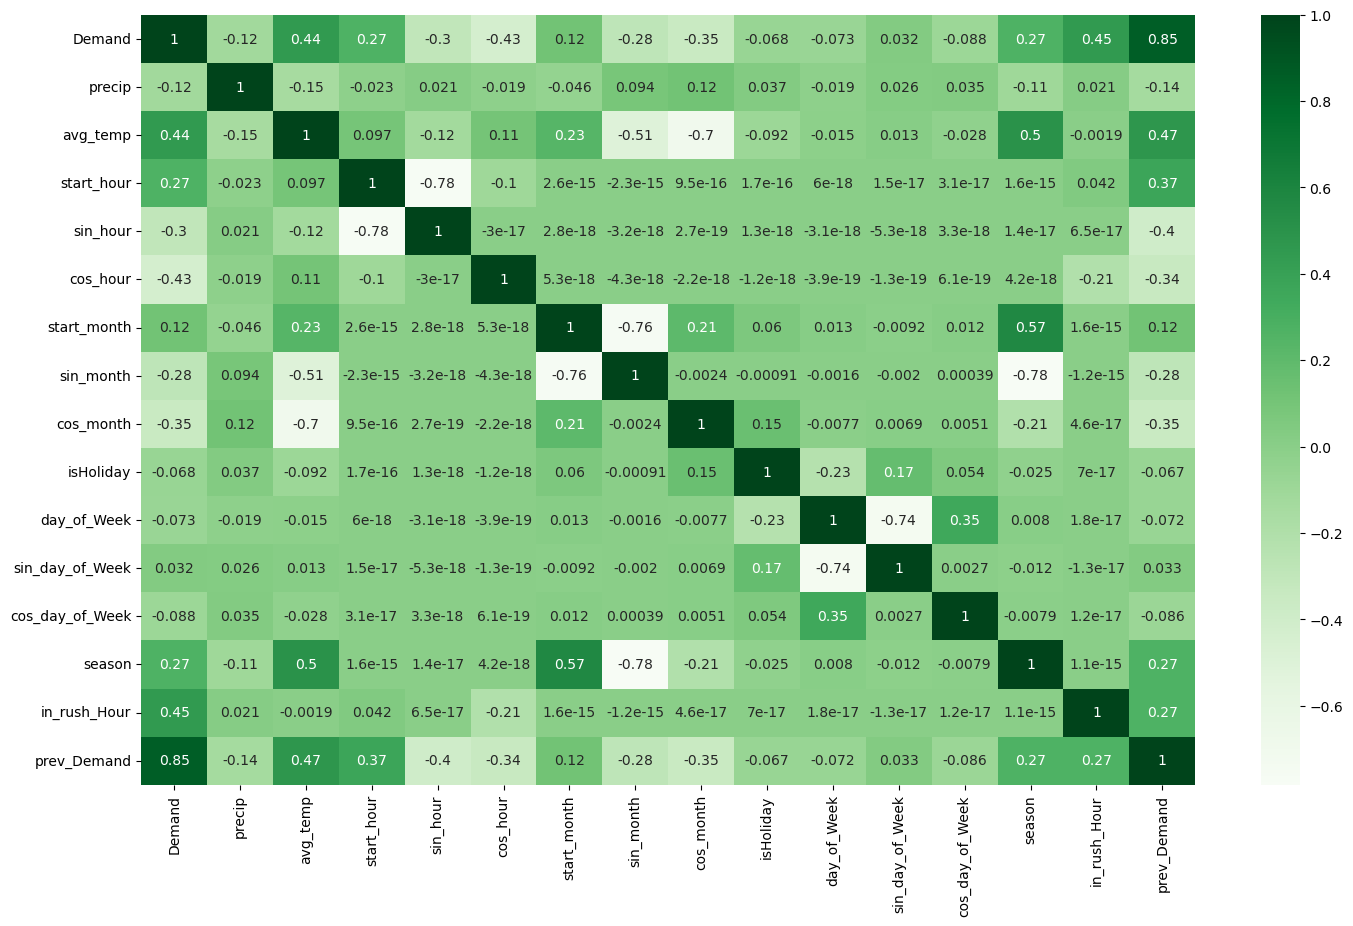

In [591]:
#visualize correlation between features

plt.figure(figsize=(17,10))
sns.heatmap(df_load_weather.corr(), cmap = 'Greens', annot = True)
plt.show()

<font size = "6">4.2 Model Building </font>

Based on the correlation matrix and our L1-Regression earlier, we have an inital combination of features we are going to use for our prediction models. Our chosen features are as follows: <b>cos_hour, sin_month, avg_temp, in_rush_Hour and prev_Demand </b>. With this (inital) selection of features, we have completed feature engineering and can now go over to the actual prediction.
We decided to chose following prediction models:

    1. Ridge (L2) - Regression
    2. Decision Tree
    3. K-Nearest Neighbors
    4. Random Forest
    
Firstly, we chose the ridge regression, because we were certain that we needed a polynomial regression. And since we wanted to check the prediction-performance of multiple features, we aimed to minimize the chance of overfitting as far as possible. The ridge-regression seemed matching, as it combined an effective runtime with the strict mitigation of overfitting.

Second, we chose Decision Tree, because... (Diego bitte die anderen hinzufügen)

For our performance metrics, we chose R^2 and MSE.


<font size = "4"> <b> Train-Test Split </b> </font>

In the first step, as with the Lasso (L1) regression earlier, we split our dataset into a training and testing part. Training containing 70% of our data and testing 30%. And again, we drop the NaN row, caused by prev_Demand and create our respective X's and y's for training and testing. We do this split to perform cross-validation later on thus accurately access our models performance later on.

In [614]:
features = ['cos_hour','sin_month','avg_temp', 'in_rush_Hour', 'prev_Demand']
#append our label Demand at the end of the array
features.append('Demand')

#features.append(features.pop(features.index('Demand')))
df1 = df_load_weather[features]

# split the data with 70% training data
train, test = train_test_split(df1, test_size = 0.3, random_state = 42)

# Drop every row that contains nan values in order for regression to work properly
test.dropna(inplace = True)
train.dropna(inplace = True)

X_train = train.iloc[:,:-1]
y_train = train.iloc[:,-1]

X_test = test.iloc[:,:-1]
y_test = test.iloc[:,-1]

In [619]:
features.pop(features.index('Demand'))

'Demand'

In [621]:
#safety check for NaN values
print(train[train.isna().any(axis=1)])

Empty DataFrame
Columns: [cos_hour, sin_month, avg_temp, in_rush_Hour, prev_Demand, Demand]
Index: []


Like the Lasso(L1) regression before, the Ridge (L2) regression penalizes high magnitudes of features, which is why scaling of our features is also essential here. And just as before, we utilize the standardscaler for this. This tool normalizes/scales of feautres, meaning it transforms in such a ways that their mean value is 0 and their standard deviation is 1. Thus, it helps the model treat the data all the same and not penalize due to different scales of features.

In [622]:
sc = StandardScaler()
X_train_scaled = sc.fit_transform(X_train)
X_test_scaled = sc.fit_transform(X_test)

<font size = "6">4.2.1 Hyperparameter Tuning </font>

<font size = "4"> <b> Polynomial Degree </b> </font>

The next steps towards actual prediction was Hyperparameter Tuning. This means that we needed to find the best values for our hyperparameters, the polynomial degree and lambda. First we tuned the polynomial degree, utilizing a standard polynomial regression. We looped through a series of possible polynomial degrees, starting from 1 and iterating up to 10. With each iteration we calculated the Mean Square Error (MSE) for both the training- and testing sets. Storing each MSE value for every polynomial degree, allowed us to compare those values and thus find the optimal polynomial degree of four, for our model. 

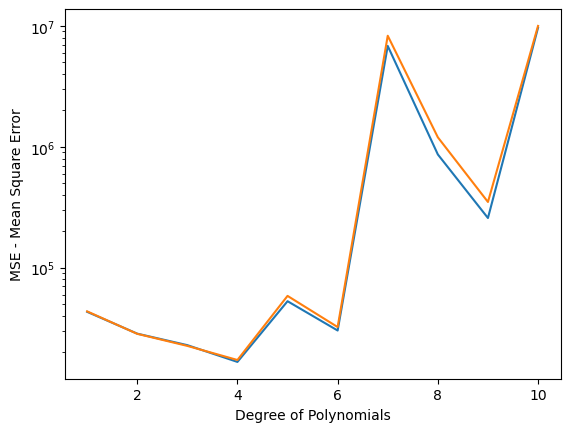

The optimal polynomial degree lies at the degree  4  with an MSE of  17230.028070968023 .


In [623]:
training_error = []
testing_error = []

for degree_poly in range (1, 11):

    poly = PolynomialFeatures(degree = degree_poly)
    X_train_poly = poly.fit_transform(X_train) 
    X_test_poly = poly.fit_transform(X_test)

    linear_reg = LinearRegression(fit_intercept = False)
    linear_reg.fit(X_train_poly, y_train)
    y_train_pred = linear_reg.predict(X_train_poly)
    y_test_pred = linear_reg.predict(X_test_poly)
    
    training_error.append(((mean_squared_error(y_train_pred, y_train))))
    testing_error.append(((mean_squared_error(y_test_pred, y_test))))

plt.semilogy(range(1,11), training_error, range(1,11), testing_error)
plt.xlabel('Degree of Polynomials')
plt.ylabel('MSE - Mean Square Error')
plt.show()

print('The optimal polynomial degree lies at the degree ', testing_error.index(min(testing_error)) + 1,
      ' with an MSE of ', min(testing_error), '.')

<font size = "4"><b>Regularization Parameter λ & Ridge (L2) Regression </b></font>

With our optimal polynomial degree determined, the next step was to find the optimal value for our regularization parameter λ (in python called alpha). For the tuning of this hyperparameter, we utilized a ridge regression, because it actually has a regularization part in its cost function.

We started by again transforming our features to polynomial features, using our optimal degree, we tuned earlier. Next we set a broad interval of possible λ's to check the regression's corresponding MSE.
Similar to the polynomial regression earlier, we stored the MSE's for both training and testing set in seperate arrays to find the minimum. 

Just like before with the polynomial regression, we fitted our data to the Ridge Regression model. Then we let it run with our different λs, simultaneously storing the MSE data in the mentioned arrays. 

After calculating all MSEs, we plotted them and noticed a slight decline of the testing set's MSE until approximately 10. After this point, the MSE seemed to increase very rapidly. Hence, we suspected the optimal λ to be around this range, meaning more in depth checking was needed for this area.


Text(0, 0.5, 'MSE - Mean Squared Error')

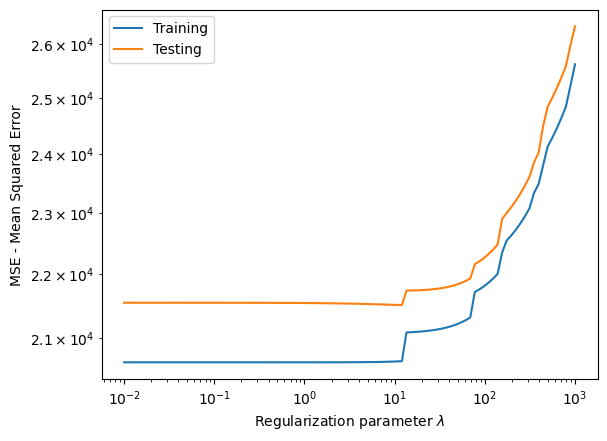

In [625]:
poly_reg = PolynomialFeatures (degree = 4)

x_poly_train_ridge = poly_reg.fit_transform(X_train_scaled)
x_poly_test_ridge = poly_reg.fit_transform(X_test_scaled)

lambd = np.logspace(-2, 3, 100)

training_error = []
testing_error = []

for l in lambd:
    
    model_ridge = Ridge(alpha = l, solver = 'lsqr')
    model_ridge.fit(x_poly_train_ridge, y_train)

    y_training_pred = model_ridge.predict(x_poly_train_ridge)
    y_test_pred = model_ridge.predict(x_poly_test_ridge)
    
    training_error.append((mean_squared_error(y_training_pred,y_train)))
    testing_error.append(mean_squared_error(y_test_pred, y_test))
    
plt.loglog(lambd, training_error, lambd, testing_error)
plt.legend(["Training", "Testing"])
plt.xlabel("Regularization parameter $\lambda$")
plt.ylabel("MSE - Mean Squared Error")

As stated above, we wanted to check the MSEs for the λ range from 10 to 16 more throroughly, since we suspected our optimal λ to be there.
Hence, we looped through every decimal λ-value within this range, ran our ridge regression with it and stored every MSE and R^2. After we found the lambda with the least MSE, we also wanted to check the models performance. Thus, we also calculated the R^2 in order to see the precision of the model.
We found the optimal lambda at 13, with an MSE of approx. 21506.422 and a R^2 Score of 0.901101.

In [648]:
data = []
for a in np.arange (10,16,0.1):
    
    alp.append(a)
    optimal_model = Ridge(alpha = a, solver = 'lsqr')
    optimal_model.fit(x_poly_train_ridge, y_train)
    y_test_pred_opt = optimal_model.predict(x_poly_test_ridge)
    data.append([a,mean_squared_error(y_test_pred_opt, y_test),r2_score(y_test_pred_opt, y_test) ])

df_error_r2_score = pd.DataFrame(data, columns = ['Lambda', 'MSE', 'R^2 Score'])


ValueError: Found input variables with inconsistent numbers of samples: [6132, 6131]

In [627]:
row = df_error_r2_score.loc[df_error_r2_score['MSE'] == df_error_r2_score['MSE'].min()]
print('The least MSE (',  df_error_r2_score['MSE'].min(),
      ') for the Testing Dataset is at the polynomial degree of 4 and the lambda '
      , row.iloc[0]['Lambda'], '.\nThe R^2 Score at this Lambda is: ', row.iloc[0]['R^2 Score'])

The least MSE ( 21506.422398138857 ) for the Testing Dataset is at the polynomial degree of 4 and the lambda  12.99999999999999 .
The R^2 Score at this Lambda is:  0.9011013998086682


Here we used our performance dataframe for the first time. We stored the calculated performance indexes for later model comparison.

In [628]:
perf_arr = [features, 'Ridge (L2)', df_error_r2_score['MSE'].min(), row.iloc[0]['R^2 Score']]
df_performance.loc[len(df_performance)] = perf_arr
df_performance.head(1)

,Feature Set,Prediction Model,MSE,R^2
0,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Ridge (L2),21506.422398,0.901101


## Decision Tree

Decision trees are commonly applied for regression tasks as they offer a efficient and comprehensive alternative to traditional regression algorithms. Decision tress can have a poor performance on the prediction of continious variables, since they are designed for classification tasks. The set of possible predictions they can make is in its size limited by the amount of leafs of the tree. This can be heavily restrictive on prediction tasks where the target variable can have large or even infinite number of realisations. However, the demand of bikes, as we defined it, is a discrete variable. Its support, is equal to the set: {0, ..., n} where n is the count of unique bikes in the dataset.

In [32]:
df_chicago['bike_id'].nunique()

6133

There are 6133 unique bikes in the dataset. This means that in theory, a decision tree with 6133 leafs with each leaf having a unique value from the set {0, ..., 6133} could make an exact prediction for every realisation of the demand. Such a tree would need a depth of log2(6133), which is approximately 13. Of course with an increasing tree depth the risk of overfitting also increases.

In [33]:
y.nunique()

1630

While the number of observed realisations is much lower, we would still need a decision tree with a depth of log2(1630), which is approximately 11, in order to completely cover all observed realisations. A tree with such a depth, might still be prone to overfitting. 

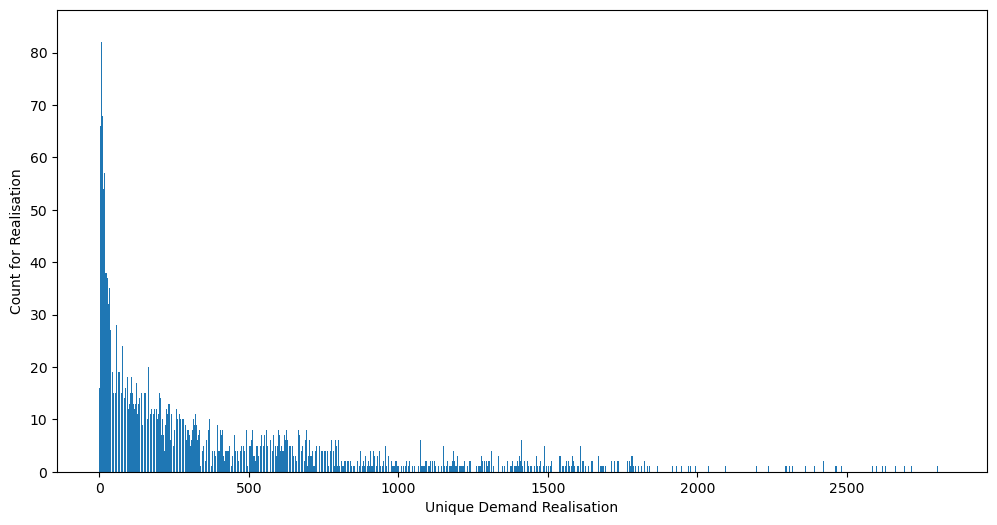

In [34]:
diag, ax = plt.subplots(figsize=(12,6))
ax.bar(y.unique(), list(map(lambda x: len(y[y == x]), y.unique())))
plt.xlabel("Unique Demand Realisation")
plt.ylabel("Count for Realisation")
plt.show()

The above plot shows every unique realisation of demand and the respective number of realisations for that demand value. As one can see, there is a heavy bias towards smaller demad values. Most observations are clustered towards lower values of demand.

In [35]:
realisation_count = list(map(lambda x: len(y[y == x]), y.unique()))
realisation_count.sort(reverse = True)
ten_percent_ratio = sum(realisation_count[0:int(len(realisation_count)* 0.1)]) / len(y)
print("The top ten percent of unique realisations acount for", ten_percent_ratio * 100, "% of all realisations")

The top ten percent of unique realisations acount for 44.12100456621005 % of all realisations


As the calculation above shows, a small amount of the unique realisations are responsible for a high count of all realisation. This combined with the clustered behaviour and the bias towards smaller demand values it is realistic to assume that a relatively small support set can suffice for relative accurate prediction of demand. For this reason, we considered decision trees as one of our approaches, as even with a small tree depth, good performance should be possible and overfitting can be avoided. Furthermore, decision trees are easy to interpret and explain, as the tree structure provides a clear representation of the decisions being made. 

#### Fit Decision Tree

When constructiong the Decision tree regressor the parameter max_depth is especially important as it controls the complexity of the decisions made by the tree. As already mentioned a high depth can lead to overfitting as the tree will make decisions which are very specific to the dataset used to tran it. The more specific these decisions become the worse they will apply to new, unseen data. In order to find an acceptable value for max_depth we train multiple decision trees with a range of depths on the training dataset. We then compare the performance of the trained tree using the mean squared error metric.

In [36]:
def fit_decision_tree(tree_depth):
    Tree_reg = DecisionTreeRegressor(
        max_depth=tree_depth,criterion="squared_error"
    )
    Tree_reg.fit(X_train, y_train)
    return Tree_reg

In [37]:
def evaluate_decision_tree_train(tree_depth):
    reg = fit_decision_tree(tree_depth)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_decision_tree_test(tree_depth):
    reg = fit_decision_tree(tree_depth)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

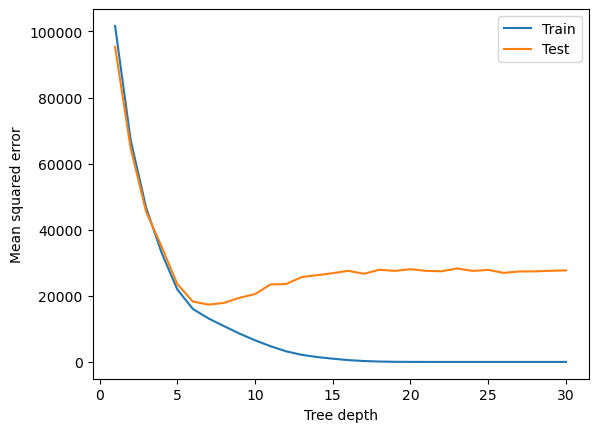

In [38]:
x = np.linspace(1, 30, 30, dtype = int)
plt.plot(x, list(map(evaluate_decision_tree_train, x)), label = 'Train')
plt.plot(x, list(map(evaluate_decision_tree_test, x)), label = 'Test')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.legend(loc=0)
plt.show()

Somewhere between a tree depth of 5 and 10 the performance on the test data starts to worsen. The following plot shows a zoomed in version.

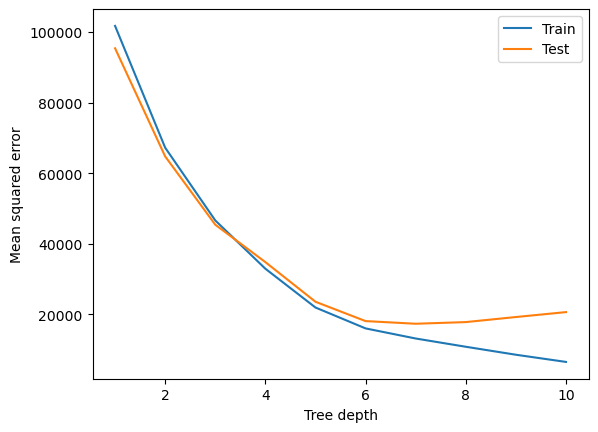

In [39]:
x = np.linspace(1, 10, 10, dtype = int)
plt.plot(x, list(map(evaluate_decision_tree_train, x)), label = 'Train')
plt.plot(x, list(map(evaluate_decision_tree_test, x)), label = 'Test')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.legend(loc=0)
plt.show()

As one can see, after a tree depth of 6 the performance on the test data decreases as most likely overfitting is occuring. Based on this we decided to use a tree depth of 6 to fit our decision tree.

In [40]:
tree_depth = 6
Tree_reg = DecisionTreeRegressor(
    max_depth=tree_depth,criterion="squared_error"
)
Tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=6)

#### Visualization

To visualize the behaviour of the decision tree we consider the feature avg_temp. The following function plots the prediction of a new tree regressor fitted only on the average temperature.

In [41]:
demand = y_train.values
average_temperature = X_train['avg_temp'].values

In [42]:
def plot_tree_regression_line(dependent_variable, regressor):

    Tree_reg = DecisionTreeRegressor(max_depth=tree_depth,
                                    criterion="squared_error") # Other options: "friedman_mse", "mae"
    Tree_reg.fit(regressor.reshape((-1,1)), dependent_variable)
    Y_pred = Tree_reg.predict(regressor.reshape((-1,1)))
    
    attributes = Tree_reg.tree_

    plt.figure(figsize = (8,6))
    plt.scatter(regressor, dependent_variable, marker="x")
    plt.plot(np.arange(-18,40,1), Tree_reg.predict(np.arange(-18,40,1).reshape((-1,1))), marker="x", color='C1')
    
    print("number of nodes: ", attributes.node_count)
    print("number of leafs: ", attributes.n_leaves)
    print("R^2: ", r2_score(dependent_variable, Y_pred))
    

number of nodes:  107
number of leafs:  54
R^2:  0.2308143599834187


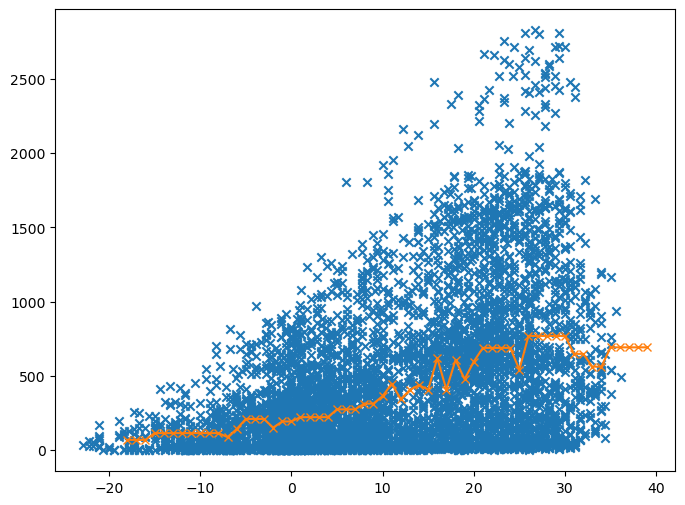

In [43]:
plot_tree_regression_line(demand, average_temperature)

As one can see the performance is poor when only considering one regressor. This was to be expected as the demand is a complex variable which can not only explained by the temperature. There might be time frames where the temperature is high but not that many people are renting bikes like during the night or evening. The average temperature alone fails to capture that complexity. However, this tree can be visualized nicely, as demonstrated in the next figure.

In [44]:
def plot_regression_tree_sklearn(dependent_variable, regressor):

    # Fit regression model (to full data)
    model = DecisionTreeRegressor(max_depth=tree_depth)
    model.fit(regressor.reshape((-1,1)), dependent_variable) 
    
    dot_data = export_graphviz(model,
                              feature_names=["avg_temp"])  
    
    graph = graphviz.Source(dot_data) 
    
    return graph

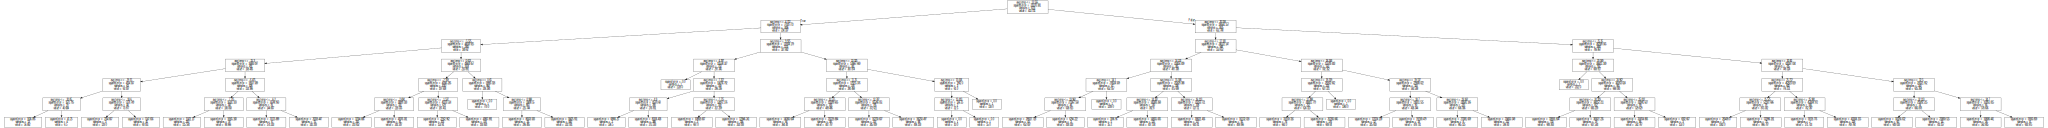

In [45]:
plot_regression_tree_sklearn(demand, average_temperature)

This tree has a max_depth of 5 as we previously defined. This means that a decision that is made by the tree goes through at most 5 conditional steps before being assigned a prediction. The root node e.g. checks the condition, whether the average temperature is above or below 13.556 degrees. Furthermore every node contains information about the squared error, the amount of samples that reached that specific node and the predition the tree would make when the given node is a leaf. This transparent decision making allows to comprehend and reproduce the results the tree produces which is in contrast to other regression approaches which are often a black box. 

## Random Forest

The random forest approach constructs a set of "weak" decision trees combining them into one "strong" model. It uses the fact that erros made by one decision tree can be canceled out by a different one, balancing the decision process and resulting in a more robust and accurate model. In essence it averages over a set of decision trees which makes it less prone to overfitting compared to a decision tree. Furthermore, in contrast to a single decision tree, random forests are less sensitive towards small changes in the dataset which can often result in large changes in the tree structure for single decision trees often negatively impacting their performance. While random forests improve on many of the disadvantages of decision trees they also lose out on some of the advantages. Opposed to decision trees which are easy to visualize random forest are harder to visualize and interpret. One can only visualize singular trees of the forest and not the entire forest. Furthermore, the decisions made in a random forest are not as transparent and hard to reconstruct. Additionally, random forests are computationally more expensive than a singular decision tree. Nevertheless, considering the improvements that random forest make on decision tree and the reasons we listed in the decison tree section we considered random forest as one of our approaches.

#### Fit random forest

Similarly to decision trees the maximum depth of the tree is relevant for tuning the model. In addition the number of trees in the forest needs to be specified. While a random forest is less prone to overfitting than a single decision tree, a forest which contains a high number of trees can still overfit on data. Furthermore such a tree has higher computational cost and memory usage, while also being harder to interpret. We want to fit the random forest using a number of trees that allows a good performance on the training and testing data while not being larger than it needs to be.

In [46]:
def fit_forest(max_depth, n_estimators = 100):
    reg = RandomForestRegressor(
        max_depth=max_depth,
        n_estimators=n_estimators,
        random_state=0
    )
    reg.fit(X_train, y_train)
    return reg

In [47]:
def evaluate_forest_train(max_depth, n_estimators = 100):
    reg = fit_forest(max_depth, n_estimators)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_forest_test(max_depth, n_estimators = 100):
    reg = fit_forest(max_depth, n_estimators)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

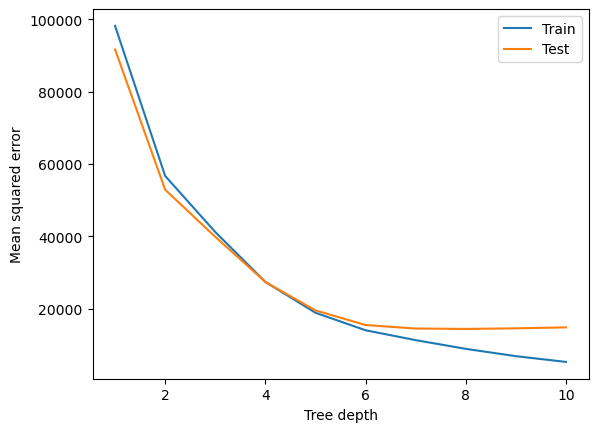

In [48]:
x = np.linspace(1, 10, 10, dtype = int)
plt.plot(x, list(map(evaluate_forest_train, x)), label = 'Train')
plt.plot(x, list(map(evaluate_forest_test, x)), label = 'Test')
plt.xlabel('Tree depth')
plt.ylabel('Mean squared error')
plt.legend(loc=0)
plt.show()

Similarly to the single decision tree, after a tree depth of 6 the peformance on the testing data starts to decrease. For that reason we chose a depth of 6 for our random forest regressor.

In [49]:
forest_depth = 6

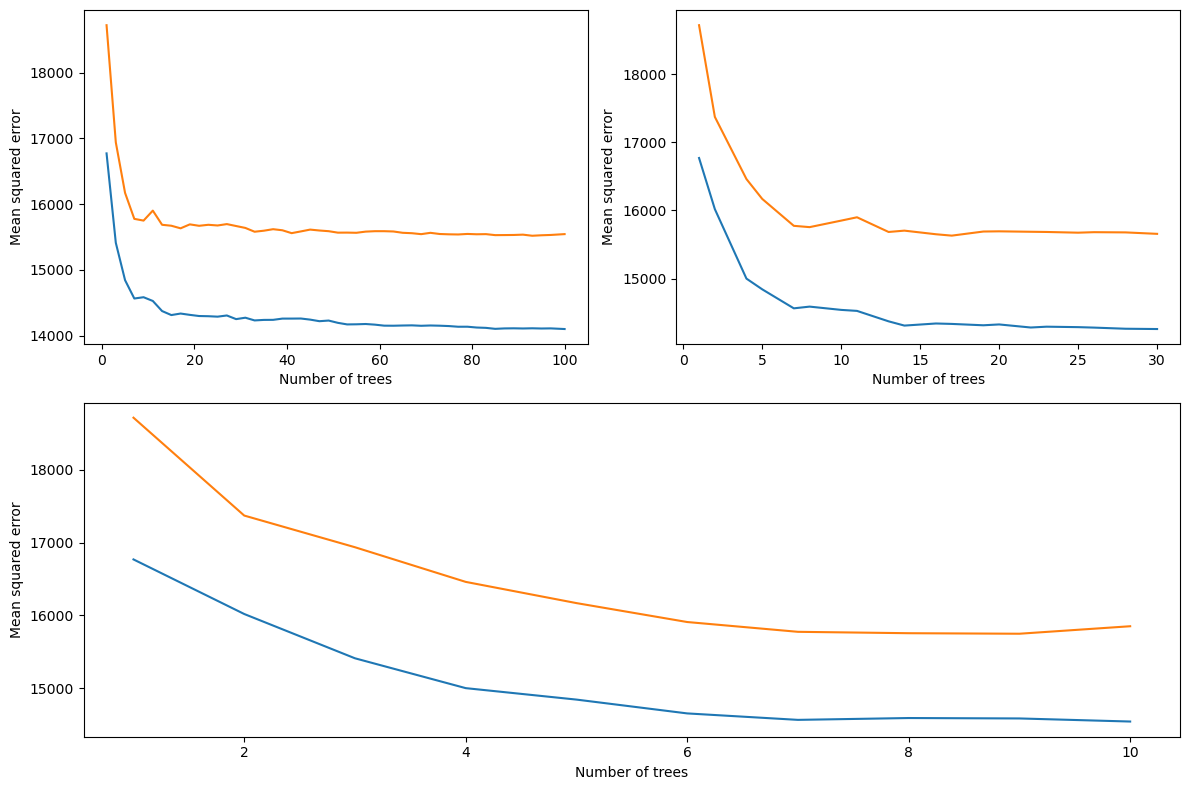

In [50]:
gs = gridspec.GridSpec(2, 2)
fig = plt.figure(figsize=(12, 8))

x1 = np.linspace(1, 100, 50, dtype = int)
x2 = [forest_depth] * 50

ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(x1, list(map(evaluate_forest_train, x2, x1)))
ax1.plot(x1, list(map(evaluate_forest_test, x2, x1)))
ax1.set_xlabel('Number of trees')
ax1.set_ylabel('Mean squared error')

x1 = np.linspace(1, 30, 20, dtype = int)
x2 = [forest_depth] * 20

ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(x1, list(map(evaluate_forest_train, x2, x1)))
ax2.plot(x1, list(map(evaluate_forest_test, x2, x1)))
ax2.set_xlabel('Number of trees')
ax2.set_ylabel('Mean squared error')

x1 = np.linspace(1, 10, 10, dtype = int)
x2 = [forest_depth] * 10

ax3 = fig.add_subplot(gs[1, :])
ax3.plot(x1, list(map(evaluate_forest_train, x2, x1)))
ax3.plot(x1, list(map(evaluate_forest_test, x2, x1)))
ax3.set_xlabel('Number of trees')
ax3.set_ylabel('Mean squared error')

plt.tight_layout()

plt.show()

As already mentioned we want to select the number of trees for our random forest so that it is as small as possible while having a good performance on the training data. In our case about 6 or 7 trees achieve similar performance to a hundred trees, which is the default value for a random forest regressor. Based on the previous reasoning we chose to construct our random forest regressor with 7 decision trees.

In [51]:
number_of_trees = 7

In [52]:
RandomForest_reg = RandomForestRegressor(
    max_depth=forest_depth, 
    n_estimators=number_of_trees, 
    random_state=0
)
RandomForest_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=6, n_estimators=7, random_state=0)

# Model Evaluation

## Decision Tree

#### Performance on training data

In [53]:
y_pred_train = Tree_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  16036.534056064686
R squared:  0.930658937141968


#### Performance on test data

In [54]:
y_pred_test = Tree_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  18280.431838782
R squared:  0.9190899148119442


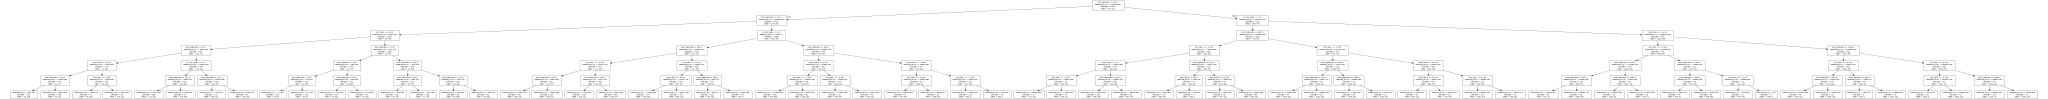

In [55]:
dot_data = export_graphviz(
    Tree_reg,
    feature_names=features
)
graph = graphviz.Source(dot_data) 
graph

## Random Forest

#### Performance on training data

In [56]:
y_pred_train = RandomForest_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  14563.576999095607
R squared:  0.9370279198359467


#### Performance on test data

In [57]:
y_pred_test = RandomForest_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  15774.54834555456
R squared:  0.9301810776847074


In [550]:
perf_arr = [features, 'Random Forest', mse , r2]
df_performance.loc[len(df_performance)] = perf_arr
df_performance.head(len(df_performance))

,Feature Set,Prediction Model,MSE,R^2
0,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Ridge (L2),21506.422398,0.901101
1,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Decision Tree,17549.074878,0.928469
2,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Random Forest,14533.005098,0.940762


## K-Nearest Neighbors

In [58]:
KNeighbor_reg = KNeighborsClassifier(n_neighbors=2)
KNeighbor_reg.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=2)

#### Performance on training data

In [59]:
y_pred_train = KNeighbor_reg.predict(X_train)

mse = mean_squared_error(y_train,y_pred_train)
print("Mean squared error: ", mse)
r2 = r2_score(y_train, y_pred_train)
print("R squared: ", r2)

Mean squared error:  45095.33110422443
R squared:  0.8050103483851463


#### Performance on test data

In [60]:
y_pred_test = KNeighbor_reg.predict(X_test)

mse = mean_squared_error(y_test,y_pred_test)
print("Mean squared error: ", mse)
r2 = r2_score(y_test, y_pred_test)
print("R squared: ", r2)

Mean squared error:  85045.56849315068
R squared:  0.6235841553234378


In [ ]:
perf_arr = [features, 'K-Nearest Neighbors', mse, r2]
df_performance.loc[len(df_performance)] = perf_arr

In [555]:
df_performance.head(len(df_performance))

,Feature Set,Prediction Model,MSE,R^2
0,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Ridge (L2),21506.422398,0.901101
1,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Decision Tree,17549.074878,0.928469
2,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",Random Forest,14533.005098,0.940762
3,"[cos_hour, sin_month, avg_temp, in_rush_Hour, ...",K-Nearest Neighbors,92506.937952,0.622935


#### Hyperparameter tuning

In [61]:
def fit_neighbors(n_neighbors):
    reg = KNeighborsClassifier(n_neighbors=n_neighbors)
    reg.fit(X_train, y_train)
    return reg

In [62]:
def evaluate_neighbors_train(n_neighbors):
    reg = fit_neighbors(n_neighbors)
    
    y_pred_train = reg.predict(X_train)
    
    return mean_squared_error(y_train,y_pred_train)

def evaluate_neighbors_test(n_neighbors):
    reg = fit_neighbors(n_neighbors)
    
    y_pred_test = reg.predict(X_test)
    
    return mean_squared_error(y_test,y_pred_test)

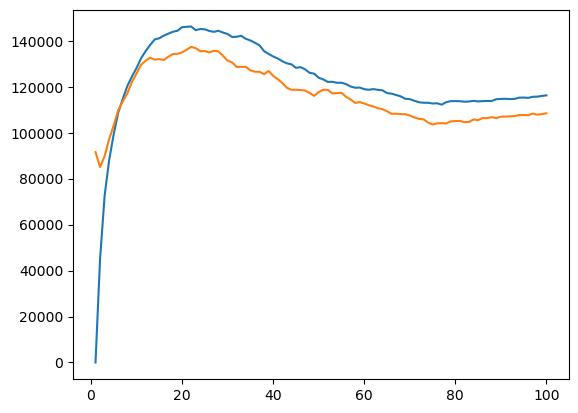

In [63]:
x = np.linspace(1, 100, 100, dtype = int)
plt.plot(x, list(map(evaluate_neighbors_train, x)))
plt.plot(x, list(map(evaluate_neighbors_test, x)))
plt.show()

<font size = "6"> <b> 4.3 Model Evaluation </b></font>



After implementing our different prediciton models, we wanted to compare them with each other, based on our performance metrics implemented. First, we to compared them based on our intial feature set <b>cos_hour, sin_month, avg_temp, in_rush_Hour and prev_Demand </b>. But we also tried different feature combinations, filtering out the most precise one to be <b> ['cos_hour', 'sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand', 'sin_hour'] </b>.

The performances of each model, using different feature sets can be seen below:

In [ ]:
# Increase size of Feature Set to see the whole set
df_performance.style.set_properties(subset = ['Feature Set'], **{'width-min': '300px'})
df_performance = df_performance.iloc[0,0]

In [661]:
test = ['cos_hour','sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand']	
#model_evaluation(test).style.set_properties(subset = ['Feature Set'], **{'width-min': '300px'})
df_performance = model_evaluation(test)
df_performance.style.set_properties(subset = ['Feature Set'], **{'width-min': '300px'})

,Feature Set,Prediction Model,MSE,R^2
0,"['cos_hour', 'sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand', 'sin_hour']",Ridge (L2),16641.098570,0.931865
1,"['cos_hour', 'avg_temp', 'in_rush_Hour', 'prev_Demand']",Ridge (L2),21713.314306,0.900843
2,"['sin_month', 'start_hour', 'avg_temp', 'in_rush_Hour', 'prev_Demand']",Ridge (L2),22730.876716,0.891749
3,"['cos_hour', 'sin_month', 'in_rush_Hour', 'prev_Demand']",Ridge (L2),24040.385997,0.889030
4,"['cos_hour', 'sin_month', 'avg_temp', 'prev_Demand']",Ridge (L2),34413.185717,0.824313
5,"['cos_hour', 'sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand', 'isHoliday']",Ridge (L2),28301.561364,0.862724
6,"['cos_hour', 'sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand', 'sin_hour']",Ridge (L2),16641.098570,0.931865
7,"['sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand', 'sin_hour']",Ridge (L2),27848.043409,0.853587
8,"['cos_hour', 'sin_month', 'avg_temp', 'in_rush_Hour', 'prev_Demand']",Ridge (L2),21506.422398,0.901101
